In [ ]:
#Extracting tickers in S&P500 that are founded before 2021.

import pandas as pd

wiki = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

tables = pd.read_html(wiki)
SP500 = tables[0]

SP500_2021 = SP500.loc[SP500['Founded'].str[:4].astype(int) < 2021, 'Symbol']
tickers2021 = [s.replace('.', '-') for s in SP500_2021]

In [ ]:
#Download data from yfinance for selected tickers of the previous part.

import yfinance as yf

Data = {}
for x in tickers2021:
  Data[x] = yf.download(x, period='1y', interval='1d', progress=False)

In [ ]:
#FIRST METRIC: This metric gives more weight to stocks with significant price increases and higher trading volumes.

import math
import numpy as np

Scores1 = []

for x in tickers2021:
  Price_change = (Data[x]['Close'][-1] - Data[x]['Close'][0]) / Data[x]['Close'][0]
  Ave_vol = sum(Data[x]['Volume'])/len(Data[x]['Volume'])
  Adj_Score = Price_change * math.log(Ave_vol)
  Scores1.append([x, Adj_Score])

Scores1.sort(key=lambda x: x[1], reverse = True)
Top10_1 = Scores1[:10]

In [ ]:
#SECOND METRIC: Linear extrapolation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

slope_parameter = []

for x in tickers2021:
  Temp = Data[x]
  X_train = np.array([i for i in range(len(Temp))]).reshape(-1, 1)
  y_train = Temp['Close'].values.reshape(-1, 1)
  model = LinearRegression()
  model.fit(X_train, y_train)
  slope_parameter.append([x, model.coef_[0][0]])

for x in slope_parameter:
  temp = x[1]*30/Data[x[0]]['Close'][-1]
  x[1] = temp
slope_parameter.sort(key=lambda x: x[1], reverse = True)
Top10_2 = slope_parameter[:10]

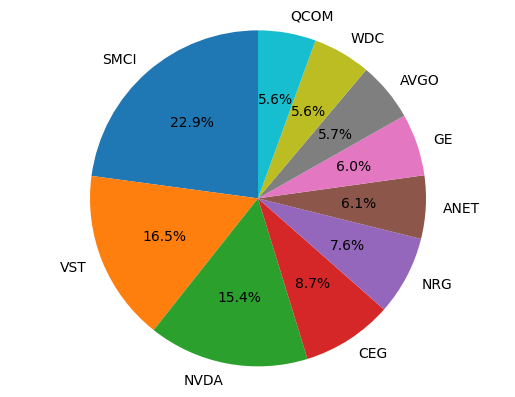

In [ ]:
import matplotlib.pyplot as plt

labels = [x[0] for x in Top10_1]
sizes = [x[1] for x in Top10_1]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

ax.axis('equal')
plt.show()

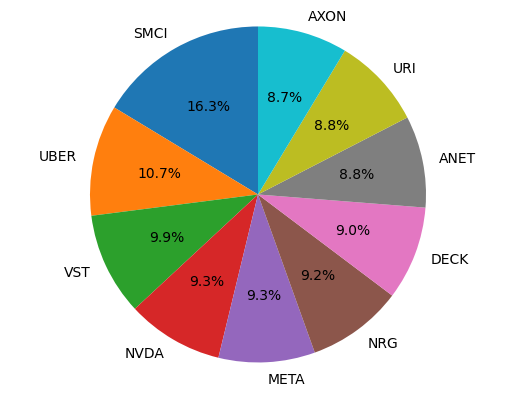

In [ ]:
labels = [x[0] for x in Top10_2]
sizes = [x[1] for x in Top10_2]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

ax.axis('equal')
plt.show()

In [ ]:
#THIRD SCORE: ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm

Scores3 =[]

for i in range(50):
  x = slope_parameter[i][0]
  Close = Data[x]['Close']
  p = q = range(0, 5)
  d = range(0, 3)
  pdq = list(itertools.product(p, d, q))
  results = []
  for param in pdq:
    try:
        model = sm.tsa.ARIMA(Close, order=param)
        model_fit = model.fit()
        results.append([param, model_fit.aic])
    except:
        continue
  results.sort(key=lambda x: x[1])
  best_params = results[0][0]
  model = sm.tsa.ARIMA(Close, order=best_params)
  model_fit = model.fit()
  forecast = model_fit.forecast(steps= 30)
  Scores3.append([x, 100*(forecast[280] - Close[-1])/Close[-1], best_params])

Scores3.sort(key=lambda x: x[1], reverse = True)
Top10_3 = Scores3[:10]
print(Top10_3)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when

[['PGR', 2425.566529266717, (4, 1, 4)], ['VST', 28.227812546274127, (3, 2, 3)], ['NVDA', 11.383745667150812, (0, 2, 3)], ['NRG', 10.9179026248416, (2, 2, 3)], ['URI', 6.454815581897096, (2, 2, 3)], ['CMG', 6.270256212640482, (0, 2, 1)], ['ANET', 6.140830832581951, (0, 2, 1)], ['AVGO', 5.922368449945256, (0, 2, 1)], ['TT', 5.820114109429274, (1, 2, 1)], ['ETN', 5.773163136467304, (2, 2, 1)]]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


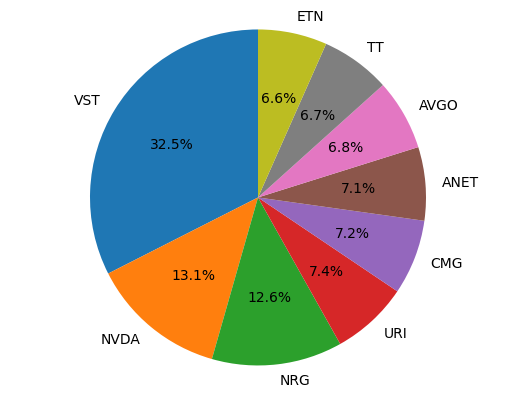

In [ ]:
A = Top10_3[1:]
labels = [x[0] for x in A]
sizes = [x[1] for x in A]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

ax.axis('equal')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


12.314153888464105
(3, 2, 3)


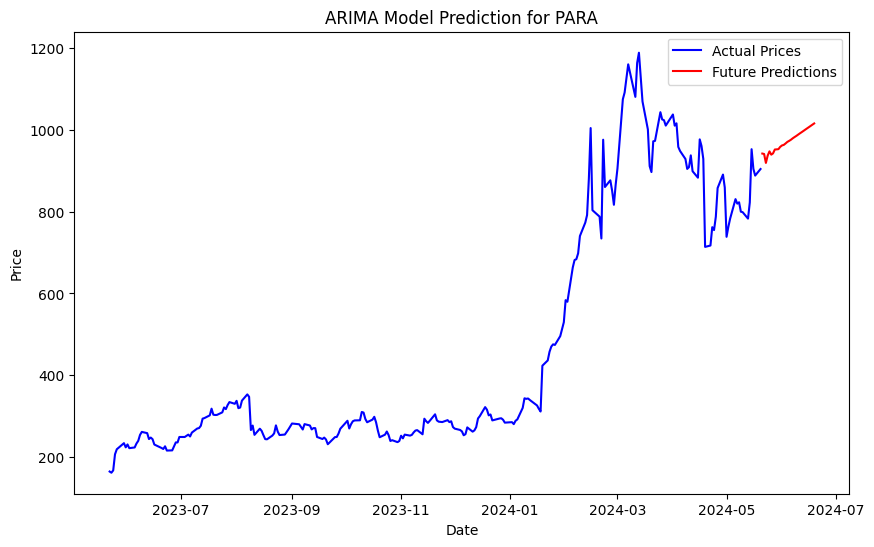

In [ ]:
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import itertools
# import statsmodels.api as sm

# Close = Data['SMCI']['Close']
# p = q = range(0, 5)
# d = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# re = []
# for param in pdq:
#   try:
#     model = sm.tsa.ARIMA(Close, order=param)
#     model_fit = model.fit()
#     re.append([param, model_fit.aic])
#   except:
#     continue
# re.sort(key=lambda x: x[1])
# best_params = results[0][0]
# model = sm.tsa.ARIMA(Close, order=best_params)
# model_fit = model.fit()
# forecast = model_fit.forecast(steps= 30)


# print(100 * (forecast[280] - Close[-1]) / Close[-1])

# print(best_params)

# plt.figure(figsize=(10, 6))
# plt.plot(Close.index, Close, label='Actual Prices', color='blue')

# future_dates = pd.date_range(start=Close.index[-1], periods=31)[1:]
# plt.plot(future_dates, forecast, label='Future Predictions', color='red')

# plt.title('ARIMA Model Prediction for PARA')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()

Top 50 of II

[['NRG', 12.340004410477196, (3, 1, 4)], ['SMCI', 12.314153888464105, (3, 2, 3)], ['NVDA', 9.337657431336241, (2, 2, 1)], ['CMG', 7.4713536137723215, (0, 2, 1)], ['ANET', 6.541251723362778, (0, 2, 1)], ['AVGO', 6.251428944429414, (0, 2, 1)], ['TT', 5.7579959291987475, (1, 2, 1)], ['ETN', 5.643868360027673, (3, 2, 4)], ['FICO', 5.578263255807902, (0, 2, 1)], ['LLY', 5.466384002668394, (1, 2, 2)]]

All

[['GS', 47.45982434004516, (4, 0, 4)], ['NRG', 12.910612205187883, (3, 1, 4)], ['SMCI', 12.578543340165242, (2, 2, 4)], ['HWM', 11.61900534724006, (2, 2, 3)], ['MTD', 10.367721964589078, (1, 2, 1)], ['APH', 10.103421746535368, (3, 2, 1)], ['NVDA', 9.357093622598892, (2, 2, 1)], ['GRMN', 8.220963465671815, (0, 2, 1)], ['CMG', 7.881242485457699, (0, 2, 1)], ['WAB', 7.728829083005916, (0, 2, 1)]]

In [ ]:
# Volume-Weighted Average Price (VWAP)

Scores4 = []

for x in tickers2021:
  VWAP = sum(Data[x]['Close'] * Data[x]['Volume'])/sum(Data[x]['Volume'])
  Scores4.append([x,(VWAP - Data[x]['Close'][-1])/Data[x]['Close'][-1]])

Scores4.sort(key = lambda x: x[1], reverse = True)
Top10_4 = Scores4[:10]

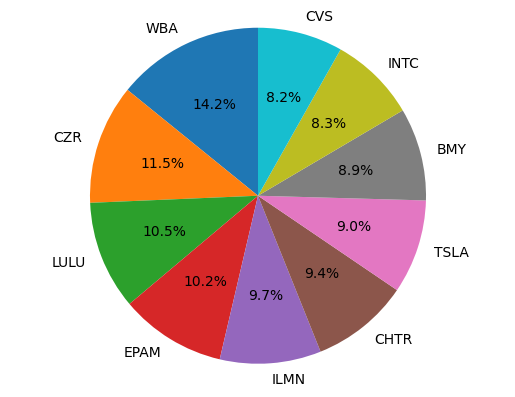

In [ ]:
labels = [x[0] for x in Top10_4]
sizes = [x[1] for x in Top10_4]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

ax.axis('equal')
plt.show()

VWAP for AAPL: 181.60


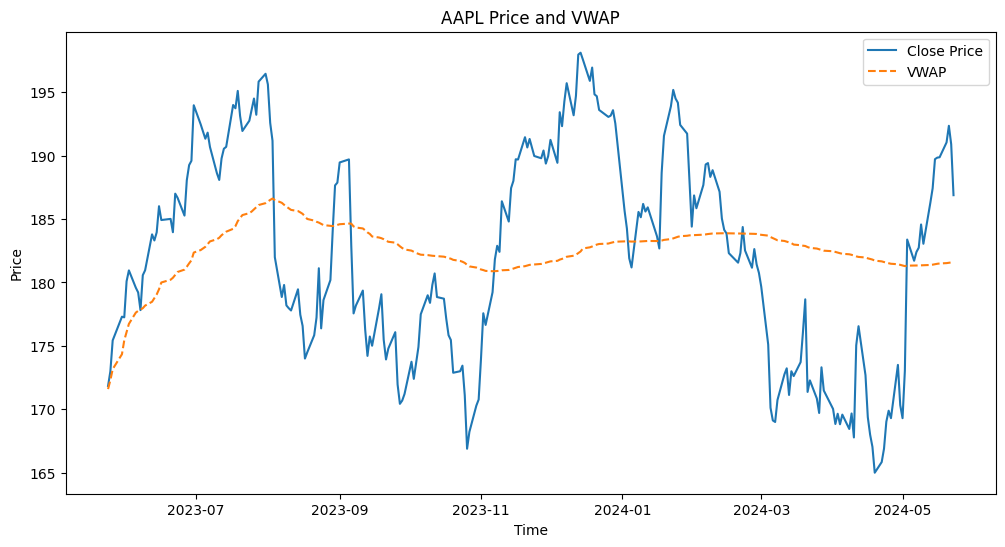

In [ ]:
import yfinance as yf
import pandas as pd

ticker = 'AAPL'

data = yf.download(ticker, period='1y', interval='1d', progress=False)

data['Typical Price'] = (data['High'] + data['Low'] + data['Close']) / 3

data['Cumulative TPV'] = (data['Typical Price'] * data['Volume']).cumsum()
data['Cumulative Volume'] = data['Volume'].cumsum()
data['VWAP'] = data['Cumulative TPV'] / data['Cumulative Volume']

vwap = data['VWAP'].iloc[-1]

print(f"VWAP for {ticker}: {vwap:.2f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(data.index, data['VWAP'], label='VWAP', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{ticker} Price and VWAP')
plt.legend()
plt.show()

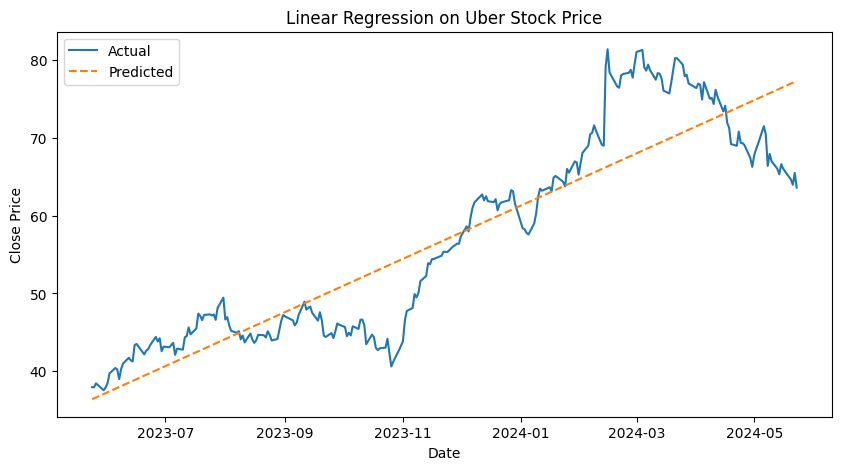

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Download Uber stock data for the last year
uber = yf.Ticker("UBER")
data = uber.history(period="1y")

# Prepare the data
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data['Date_ordinal'] = data['Date'].apply(lambda date: date.toordinal())

X = data[['Date_ordinal']]
y = data['Close']

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Predict values
data['Predicted_Close'] = model.predict(X)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Close'], label='Actual')
plt.plot(data['Date'], data['Predicted_Close'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression on Uber Stock Price')
plt.legend()
plt.show()